In [26]:
from __future__ import division, print_function

import os
from datetime import datetime

# Ignore warnings
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from skimage import io, transform
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from sklearn.metrics import average_precision_score, accuracy_score

warnings.filterwarnings("ignore")


import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import random
import albumentations as A
from math import ceil
from collections import Counter
from art.defences.preprocessor import GaussianAugmentation

In [27]:
import sys
sys.path.append("./src")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
%load_ext autoreload
%autoreload 2

from src.dataset import NodulesDataset
from src.augmentations import create_mip
from src.custom_models import resnet3d, resnet3d_bounded_relu
from src.schedulers.cosine_annearing_with_warmup import CosineAnnealingWarmupRestarts

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Prepare data

In [29]:
dataset = NodulesDataset("data/nodules")

In [30]:
len(dataset)

837

In [31]:
Counter(dataset.labels)

Counter({1: 395, 0: 442})

In [32]:
def visualize_classes(dataset: Dataset, classes: list = [0, 1], columns: int = 6, inv_normalize = None):
    np.random.seed(0)
    classes_ids = [[] for _ in range(len(classes))]
    for i, class_ in enumerate(classes):
        for _ in range(columns):
            id_ = np.random.randint(len(dataset), size=1)[0]
            while dataset[id_][1] != class_:
                id_ = np.random.randint(len(dataset), size=1)[0]
            classes_ids[i].append(id_)
    f, ax = plt.subplots(len(classes), columns)
    f.set_size_inches(18.5, 10.5)
    for i in range(len(classes)):
        for j in range(columns):
            ax[i, j].set_title(f"id - {classes_ids[i][j]}; label - {dataset[classes_ids[i][j]][1]}")
            image = dataset[classes_ids[i][j]][0]
            if inv_normalize is not None:
                image = inv_normalize(image)
            if isinstance(image, torch.Tensor):
                image = image.permute(1, 2, 0).numpy()
            ax[i, j].imshow(image, cmap="gray")
            ax[i, j].axis('off')

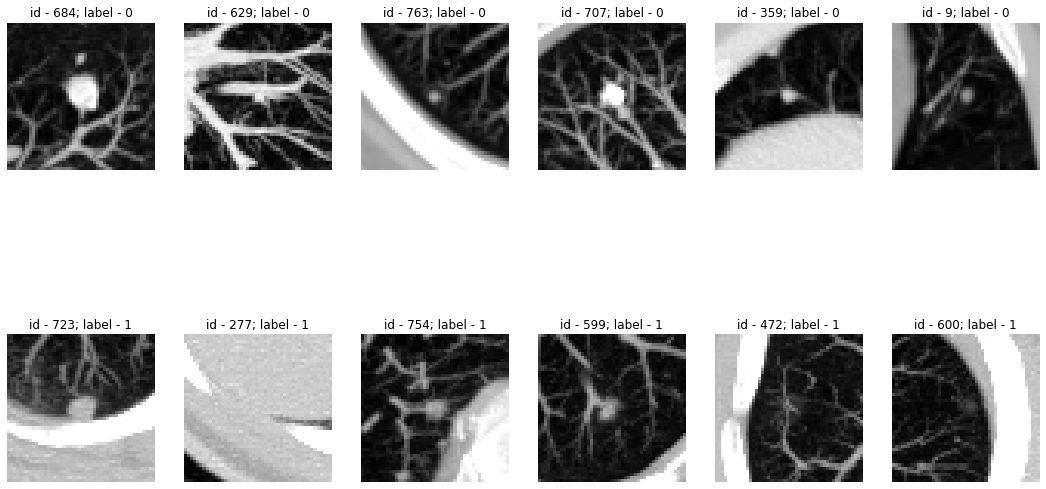

In [33]:
visualize_classes(dataset, inv_normalize=create_mip)

In [34]:
original_dataset = NodulesDataset(
    "data/nodules", 
    transform=transforms.Compose(
        [
            lambda x: x/255,
            lambda x: x[np.newaxis, :, :, :],
            lambda x: torch.tensor(x, dtype=torch.float32),
#             lambda x: transforms.RandomHorizontalFlip(p=0.5)(x[0]).unsqueeze(0),
#             lambda x: transforms.RandomVerticalFlip(p=0.5)(x[0]).unsqueeze(0),
        ]
    )
)

In [35]:
train_size = int(0.8 * len(original_dataset))
test_size = len(original_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    original_dataset, [train_size, test_size], torch.Generator().manual_seed(0)
)

In [36]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=16, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=16, shuffle=True, num_workers=2
)

In [37]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images.shape, labels.shape

(torch.Size([16, 1, 48, 48, 48]), torch.Size([16]))

### Train model

In [38]:
def epoch(loader, model, device, criterion, opt=None):
    probabilities = []
    all_labels = []
    total_loss = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_loss += loss.item() * inputs.size(0)
        all_labels.extend(list(labels.cpu().detach().numpy().reshape(-1)))
        probabilities.extend(list(outputs.cpu().detach().numpy()[:, 1].reshape(-1)))
    return total_loss / float(len(loader.dataset)), all_labels, probabilities

In [39]:
def print_metrics(writer, phase, epoch_num, loss, labels, prob, lr=None):
    acc = accuracy_score(labels, (np.array(prob) > 0.5).astype(int))
    ap = average_precision_score(labels, prob)

    writer.add_scalar(f'Loss', loss, epoch_num)
    writer.add_scalar(f'Accuracy', acc, epoch_num)
    writer.add_scalar(f'Average precision', ap, epoch_num)
    if lr is not None:
        writer.add_scalar(f'LR', lr, epoch_num)
        print(f"{phase} Loss: {loss:.4f} Acc: {acc:.4f} AP: {ap:.4f} LR: {lr}")
    else:
        print(f"{phase} Loss: {loss:.4f} Acc: {acc:.4f} AP: {ap:.4f}")

In [40]:
def create_writers(log_dir: str = "./runs"):
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    train_log_dir = f"{log_dir}/{current_time}/train/"
    val_log_dir = f"{log_dir}/{current_time}/val/"
    train_writer = SummaryWriter(log_dir=train_log_dir)
    val_writer = SummaryWriter(log_dir=val_log_dir)
    return train_writer, val_writer

In [41]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100.0
    best_epoch = 0
    train_writer, val_writer = create_writers("./runs")
    model.train()

    for epoch_num in range(num_epochs):
        print(f"Epoch {epoch_num}/{num_epochs - 1}")
        print("-" * 10)

        train_loss, train_labels, train_prob = epoch(train_loader, model, device, criterion, opt = optimizer)
        val_loss, val_labels, val_prob = epoch(test_loader, model, device, criterion)

        print_metrics(train_writer, "train", epoch_num, train_loss, train_labels, train_prob, optimizer.param_groups[0]["lr"])
        print_metrics(val_writer, "val", epoch_num, val_loss, val_labels, val_prob)

        scheduler.step(epoch_num)

        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch_num
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val loss: {best_loss:4f} Best epoch: {best_epoch}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [42]:
device = "cuda:0"
# device = "cpu"

In [70]:
model_ft = resnet3d.resnet18()

model_ft.fc = nn.Sequential(
    nn.Linear(model_ft.fc.in_features, 2),
#     nn.Softmax(),
)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

model_ft.apply(init_weights)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001, weight_decay=0.001)

# exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft
# , 'min', patience=5, eps=1e-07)
exp_lr_scheduler = CosineAnnealingWarmupRestarts(optimizer_ft,
                                                 first_cycle_steps=40,
                                                 cycle_mult=1.5,
                                                 max_lr=0.0001,
                                                 min_lr=1e-8,
                                                 warmup_steps=5,
                                                 gamma=0.9)
# exp_lr_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer_ft,
#                                                   T_0=40,
#                                                   T_mult=2,
#                                                   eta_min=1e-8)

In [71]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=326
)

Epoch 0/325
----------
train Loss: 0.7146 Acc: 0.5217 AP: 0.4709 LR: 1e-08
val Loss: 0.7215 Acc: 0.5179 AP: 0.4257

Epoch 1/325
----------
train Loss: 0.7146 Acc: 0.5232 AP: 0.4655 LR: 1e-08
val Loss: 0.7219 Acc: 0.5298 AP: 0.4162

Epoch 2/325
----------
train Loss: 0.6796 Acc: 0.5710 AP: 0.5753 LR: 2.0008000000000002e-05
val Loss: 0.6477 Acc: 0.6250 AP: 0.6460

Epoch 3/325
----------
train Loss: 0.6332 Acc: 0.6517 AP: 0.6883 LR: 4.0006e-05
val Loss: 0.6016 Acc: 0.6786 AP: 0.7108

Epoch 4/325
----------
train Loss: 0.5983 Acc: 0.7025 AP: 0.7306 LR: 6.000400000000001e-05
val Loss: 0.5902 Acc: 0.7083 AP: 0.7543

Epoch 5/325
----------
train Loss: 0.5910 Acc: 0.7190 AP: 0.7175 LR: 8.0002e-05
val Loss: 0.5951 Acc: 0.7024 AP: 0.7165

Epoch 6/325
----------
train Loss: 0.5851 Acc: 0.7190 AP: 0.7541 LR: 0.0001
val Loss: 0.6217 Acc: 0.6667 AP: 0.6425

Epoch 7/325
----------
train Loss: 0.5451 Acc: 0.7534 AP: 0.8212 LR: 9.979873482829199e-05
val Loss: 0.5789 Acc: 0.7560 AP: 0.7747

Epoch 8/325


### Analyze results

In [72]:
val_image = []
val_true = []
val_pred = []
val_prob = []
model_ft.eval()
with torch.no_grad():
    for inputs, batch_labels in tqdm(test_loader):
        inputs = inputs.to("cuda:0")
        outputs = model_ft(inputs)
        prob = outputs.to("cpu").numpy()[:, 1]
        preds = (prob > 0.5).astype(int)
        val_prob.extend(prob)
        val_pred.extend(preds)
        val_true.extend(batch_labels.to("cpu").numpy())
        val_image.extend(inputs.to("cpu"))

100%|██████████| 11/11 [00:00<00:00, 46.40it/s]


In [73]:
def error_class(row):
    if row["true"] == row["pred"] == 1:
        return "TP"
    elif row["true"] == row["pred"] == 0:
        return "TN"
    elif row["true"] != row["pred"] and row["pred"] == 1:
        return "FP"
    else:
        return "FN"

In [74]:
df = pd.DataFrame({"true": val_true, "pred": val_pred, "prob": val_prob})

In [75]:
df

,true,pred,prob
0,0,0,0.000898
1,0,0,0.000004
2,0,0,0.010981
3,1,1,0.999995
4,1,1,0.999999
...,...,...,...
163,1,0,0.038605
164,0,0,0.000003
165,0,0,0.000005
166,0,1,0.999986


In [76]:
df["error_type"] = df.apply(error_class, axis=1)

In [77]:
df.groupby("error_type").count()

,true,pred,prob
error_type,,,
FN,15,15,15
FP,12,12,12
TN,78,78,78
TP,63,63,63


In [78]:
print(f"accuracy_score - {accuracy_score(df['true'], df['pred'])}")
print(f"average_precision_score - {average_precision_score(df['true'], df['pred'])}")

accuracy_score - 0.8392857142857143
average_precision_score - 0.7677472527472528


In [79]:
n = 10
def view_images(df: pd.DataFrame, images: np.ndarray, columns: int = 5, fig_size: tuple = (18.5, 10.5)):
    f, ax = plt.subplots(ceil(df.shape[0] / columns), columns)
    f.set_size_inches(*fig_size)
    for i, (id_, row) in enumerate(df.iterrows()):
        if ax.ndim  == 2:
            current_ax = ax[i // columns, i % columns]
        else:
            current_ax = ax[i]
        current_ax.set_title(str(row))
        current_ax.imshow(create_mip(images[id_][0]))
        current_ax.axis('off')

In [80]:
df

,true,pred,prob,error_type
0,0,0,0.000898,TN
1,0,0,0.000004,TN
2,0,0,0.010981,TN
3,1,1,0.999995,TP
4,1,1,0.999999,TP
...,...,...,...,...
163,1,0,0.038605,FN
164,0,0,0.000003,TN
165,0,0,0.000005,TN
166,0,1,0.999986,FP


In [81]:
# view_images(df[df["error_type"]=="TP"].sample(5), val_image)

In [82]:
# view_images(df[df["error_type"]=="TN"].sample(5), val_image)

In [83]:
# view_images(df[df["error_type"]=="FP"].sample(5), val_image)

In [84]:
# view_images(df[df["error_type"]=="FN"].sample(5), val_image)

### Save model

In [85]:
save_path = f"./models/3.2_resnet_{datetime.now().strftime('%Y-%m-%d_%H:%M:%S')}.pt"
torch.save(model_ft.state_dict(), save_path)
save_path

'./models/3.2_resnet_2021-06-04_18:00:35.pt'

In [88]:
model = resnet3d.resnet18()
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 2),
)

# model.load_state_dict(torch.load(save_path))
model.load_state_dict(torch.load("./models/3.2_resnet_brelu_2021-06-04_17:44:19.pt"))
del model.layer3
del model.layer4
model.eval()

ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [89]:
model = resnet3d_bounded_relu.resnet18()
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 2),
)

del model.layer3
del model.layer4
model

ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU6(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU6(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru